In [38]:
#!pip install pygobject, playsound

In [1]:
#импорт библиотек
import numpy as np  # для матричных вычислений
import pandas as pd  # для анализа и предобработки данных
import matplotlib.pyplot as plt  # для визуализации
import seaborn as sns  # для визуализации

from sklearn import linear_model  # линейные моделиё
from sklearn import tree  # деревья решений
from sklearn import ensemble  # ансамбли
from sklearn import metrics  # метрики
from sklearn import preprocessing  # предобработка
from sklearn.model_selection import train_test_split  # сплитование выборки

from playsound import playsound

%matplotlib inline
plt.style.use('seaborn')


/tmp/ipykernel_155251/3675450675.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [9]:
def f1_test():
    global y_test
    global y_test_pred
    print(
        f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred):.3f}')


In [15]:
def best_params(searcher):
    print(f'Наилучшие значения гиперпараметров: {searcher.best_params_}')


In [40]:
def done():
    playsound('sounds/zvuk-vyipolnennogo-deystviya.mp3')


In [2]:
data = pd.read_csv('data/train.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


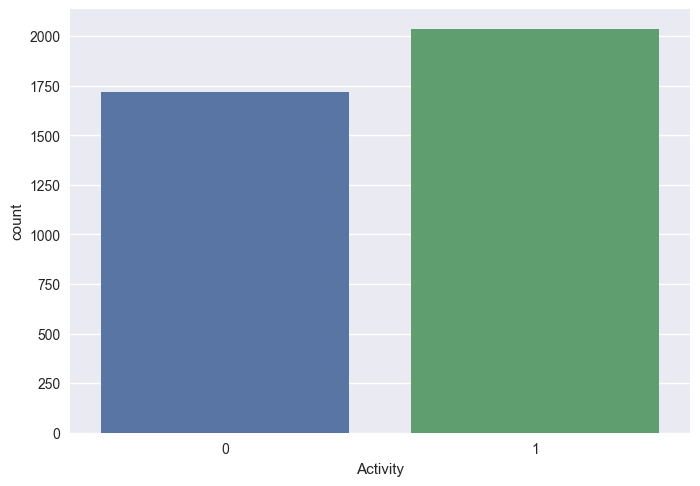

In [3]:
sns.countplot(data=data, x='Activity');

Данные практически сбалансированы по целевому признаку, однако для сохранения долей данных с различным значеним целевой переменной применим стратификацию.

In [4]:
X = data.drop(columns=['Activity'])
y = data['Activity']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

Создадим модель линейной регрессии с параметрами по умолчанию.

In [6]:
# Забегая вперед. 100 итераций по умолчанию оказалось мало. Модель не сошлась. Поэтому поставим 
lr = linear_model.LogisticRegression(max_iter=1000, random_state=42)

Обучим модель на тренировочной выборке:

In [7]:
lr.fit(X_train, y_train)
done()

LogisticRegression(max_iter=1000, random_state=42)

Сделаем предсказание на тестовой выборке:

In [8]:
y_test_pred = lr.predict(X_test)

Посмотрим на метрику $F1$ по результатам классификации:

In [10]:
f1_test()

f1_score на тестовом наборе: 0.780


Уже видим, что модель логистической регрессии даёт хорошие результаты даже без добавления полиномиальных признаков и с настройками по умолчанию.

Создадим случайный лес с параметрами по умолчанию.

In [11]:
rf = ensemble.RandomForestClassifier(random_state=42)

Обучим его на тренировочной выборке.

In [12]:
rf.fit(X_train, y_train)
done()

RandomForestClassifier(random_state=42)

Сделаем предсказание на тестовой выборке.

In [13]:
y_test_pred = rf.predict(X_test)

Посмотрим на метрику $F1$ по результатам классификации:

In [14]:
f1_test()

f1_score на тестовом наборе: 0.793


#### Видим, что значения целевой метрики $F1$ улучшились.

### Подбор гиперпараметров с помощью GridSearchCV для логистической регрессии

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l2'],  # тип регурялизации
    'solver': ['lbfgs', 'sag', 'saga'],  # алгоритм оптимизации
    'C': [0.1, 0.45, 1],
    'warm_start': [True]
    }

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42,  # генератор случайных чисел
        max_iter=1000  # количество итераций на сходимость
    ),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

%time grid_search.fit(X_train, y_train)
done()
y_test_pred = grid_search.predict(X_test)
f1_test()
best_params(grid_search)

CPU times: user 11.5 s, sys: 6.95 s, total: 18.4 s
Wall time: 2min 57s
f1_score на тестовом наборе: 0.789
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}


#### Видим, что подбор гиперпараметров логистической регрессии дал немного худший результат метрики $F1$ на тесте, чем случайный лес с параметрами по умолчанию (0,789 против 0,793). В связи с этим в дальнейшем работать с моделью логистической регрессии не будем.

### Подбор гиперпараметров случайного леса с помощью GridSearchCV


In [33]:
param_grid = {
    'n_estimators': list(range(238, 243, 1)),
    'min_samples_leaf': list(range(1, 5, 1)),
    'max_depth': list(range(4, 15, 2))
    }

grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
%time grid_search_forest.fit(X_train, y_train)
done()
y_test_pred = grid_search_forest.predict(X_test)
f1_test()
best_params(grid_search_forest)

CPU times: user 6.66 s, sys: 544 ms, total: 7.2 s
Wall time: 6min 27s
f1_score на тестовом наборе: 0.795
Наилучшие значения гиперпараметров: {'max_depth': 14, 'min_samples_leaf': 3, 'n_estimators': 240}


#### Видим, что метрика $F1$ поднялась до 0.795 для модели случайного леса после подбора гиперпараметров по решетке.

### Осуществим подбор гиперпараметров при помощи случайного поиска.

In [35]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': list(range(230, 251, 1)),
    'min_samples_leaf': list(range(1, 10, 1)),
    'max_depth': list(range(1, 30, 1))
    }

random_search = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    cv=5,
    n_iter=30,
    n_jobs=-1
)
%time random_search.fit(X_train, y_train)
done()
y_test_pred = random_search.predict(X_test)
f1_test()
best_params(random_search)

CPU times: user 3.52 s, sys: 287 ms, total: 3.81 s
Wall time: 1min 56s
f1_score на тестовом наборе: 0.795
Наилучшие значения гиперпараметров: {'n_estimators': 241, 'min_samples_leaf': 3, 'max_depth': 14}


#### Видим, что значение метрики $F1$ на гиперпараметрах подобранных случайным поиском такое же как при поиске по решетке, параметры мемного отличаются, но затрачено гораздо меньше времени.

### Осуществим подбор гиперпараметров случайного леса при помощи Hyperopt, используя кросс-валидацию

In [42]:
#!pip install hyperopt

In [43]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print(f"Версия Hyperopt : {hyperopt.__version__}")


Версия Hyperopt : 0.2.7


In [44]:
# зададим пространство поиска гиперпараметров
space = {
    'n_estimators': hp.quniform('n_estimators', 230, 250, 1),
    'max_depth': hp.quniform('max_depth', 1, 30, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
    }


Создадим функцию, которую будет минимизировать Hyperopt

In [45]:
# зафксируем random_state
random_state = 42


def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_samples_leaf': int(params['min_samples_leaf'])
        }

    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(
        **params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)

    # применяем кросс-валидацию для оценки среднего значения метрики на всех фолдах
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


In [48]:
%%time
# начинаем подбор гиперпараметров

trials = Trials()  # используется для логирования результатов

best = fmin(hyperopt_rf,  # наша функция
            space=space,  # пространство гиперпараметров
            algo=tpe.suggest,  # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
            max_evals=20,  # максимальное количество итераций
            trials=trials,  # логирование результатов
            # фиксируем для повторяемости результата
            rstate=np.random.default_rng(random_state)
            )
done()
print(f'Наилучшие значения гиперпараметров {best}')


100%|██████████| 20/20 [01:54<00:00,  5.71s/trial, best loss: -0.8208963900874122]
Наилучшие значения гиперпараметров {'max_depth': 14.0, 'min_samples_leaf': 2.0, 'n_estimators': 245.0}
CPU times: user 40.9 s, sys: 513 ms, total: 41.4 s
Wall time: 1min 57s


Посмотрим на значение метрики $F1$ на подобранных параметрах

In [49]:
model = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
done()
y_test_pred = model.predict(X_test)
f1_test()

f1_score на тестовом наборе: 0.795


#### Видим, что значение метрики такое же, как при поиске параметров по решетке и случайным образом, хотя параметры найденные Hyperopt немного отличаются.

Предпримем еще несколько попыток подбора параметров:

In [50]:
# если необходимо продолжить подбор,
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях)
# и используем старый trials
best = fmin(hyperopt_rf,  # наша функция
            space=space,  # пространство гиперпараметров
            algo=tpe.suggest,  # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
            max_evals=23,  # максимальное количество итераций
            trials=trials,  # логирование результатов
            # фиксируем для повторяемости результата
            rstate=np.random.default_rng(random_state)
            )
done()
print(f'Наилучшие значения гиперпараметров {best}')


100%|██████████| 23/23 [00:28<00:00,  9.66s/trial, best loss: -0.8211094588236747]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 1.0, 'n_estimators': 242.0}


Посмотрим, какая метрика $F1$ получится теперь

In [51]:
model = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
done()
y_test_pred = model.predict(X_test)
f1_test()


f1_score на тестовом наборе: 0.800


#### Здорово! Всего три дополнительные итерации подбора позволили нам достичь показателя $F1=0.8$, чего пока не давала ни одна модель

Отрисуем график изменения $F1$ в зависимости от параметров при подборе

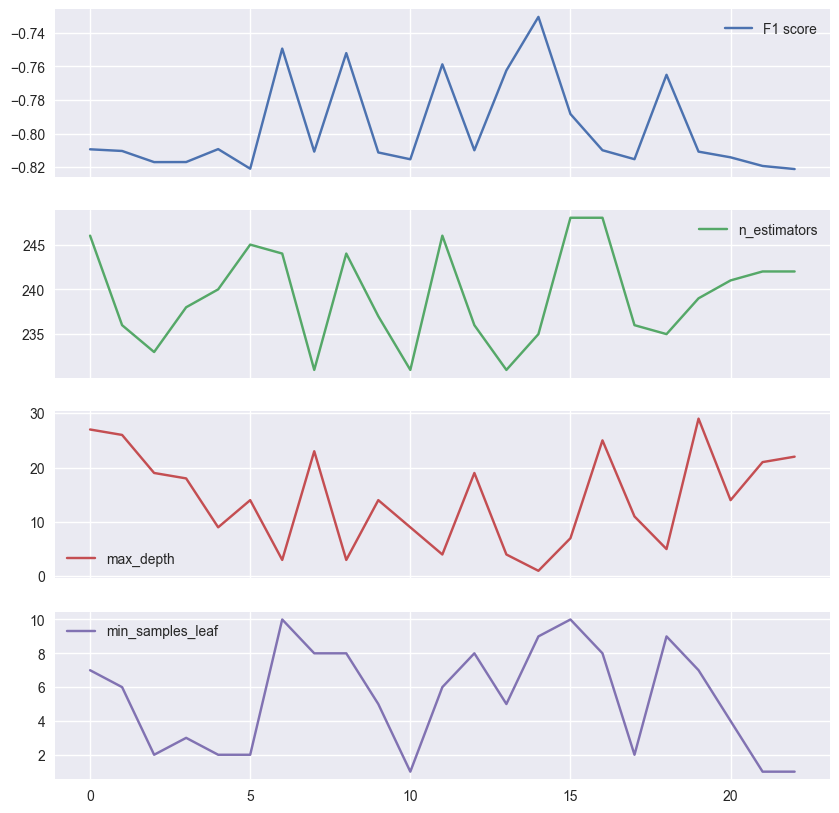

In [55]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array(
    [[x['result']['loss'],
    x['misc']['vals']['n_estimators'][0],
    x['misc']['vals']['max_depth'][0],
    x['misc']['vals']['min_samples_leaf'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(
    tpe_results,
    columns=['F1 score', 'n_estimators', 'max_depth', 'min_samples_leaf'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

### Произведем подбор гиперпараметров случайного леса при помощи Optuna

In [56]:
# Устанавливаем библиотеку
#!pip install optuna
# или
#!conda install -c conda-forge optuna


In [57]:
import optuna

print(f"Версия Optuna: {optuna.__version__}")


Версия Optuna: 3.1.0


In [58]:
def optuna_rf(trial, cv=5, scoring='f1', n_jobs=-1):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 230, 250, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  
  # Для оценки метрики используем кросс-валидацию
  score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=n_jobs).mean()
  
  return score


In [59]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)
done()

[I 2023-04-23 13:25:49,616] A new study created in memory with name: RandomForestClassifier
[I 2023-04-23 13:26:03,340] Trial 0 finished with value: 0.8138994880282878 and parameters: {'n_estimators': 240, 'max_depth': 26, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8138994880282878.
[I 2023-04-23 13:26:12,546] Trial 1 finished with value: 0.8004110587976427 and parameters: {'n_estimators': 238, 'max_depth': 18, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8138994880282878.
[I 2023-04-23 13:26:21,941] Trial 2 finished with value: 0.8126969222127547 and parameters: {'n_estimators': 244, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8138994880282878.
[I 2023-04-23 13:26:29,231] Trial 3 finished with value: 0.7961995910966516 and parameters: {'n_estimators': 236, 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8138994880282878.
[I 2023-04-23 13:26:37,164] Trial 4 finished with value: 0.8000970962818291 and parameters: {'n

CPU times: user 57.1 s, sys: 907 ms, total: 58 s
Wall time: 3min 18s


In [60]:
# выводим результаты на обучающей выборке
print(f"Наилучшие значения гиперпараметров {study.best_params}")
print(f"f1_score на обучающем наборе: {study.best_value:.2f}")


Наилучшие значения гиперпараметров {'n_estimators': 232, 'max_depth': 24, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.82


Посмотрим на значение метрики $F1$ на тестовом наборе данных

In [61]:
model = ensemble.RandomForestClassifier(
    **study.best_params, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)
done()
y_test_pred = model.predict(X_test)
f1_test()


f1_score на тестовом наборе: 0.803


#### Потрясающе! Optuna удалось улучшить метрику $F1$ еще на три тысячных!

Проведем еще 20 итераций

In [62]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям)
study.optimize(optuna_rf, n_trials=20)
done()


[I 2023-04-23 13:33:11,442] Trial 20 finished with value: 0.8069101638289599 and parameters: {'n_estimators': 250, 'max_depth': 18, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.8165444997820801.
[I 2023-04-23 13:33:21,722] Trial 21 finished with value: 0.8160334907486945 and parameters: {'n_estimators': 237, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.8165444997820801.
[I 2023-04-23 13:33:31,597] Trial 22 finished with value: 0.8157604787895242 and parameters: {'n_estimators': 237, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.8165444997820801.
[I 2023-04-23 13:33:42,191] Trial 23 finished with value: 0.8156541810493707 and parameters: {'n_estimators': 234, 'max_depth': 23, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.8165444997820801.
[I 2023-04-23 13:33:51,948] Trial 24 finished with value: 0.8095782280397665 and parameters: {'n_estimators': 233, 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 16 with va

CPU times: user 59.7 s, sys: 673 ms, total: 1min
Wall time: 3min 32s


In [66]:
model = ensemble.RandomForestClassifier(
    **study.best_params, random_state=random_state, n_jobs=-1)
model.fit(X_train, y_train)
done()
y_test_pred = model.predict(X_test)
f1_test()

f1_score на тестовом наборе: 0.798


#### Видим,что на последних трёх итерациях Optuna улучшала метрику. При этом значение метрики $F1$ снизилось на тестовом наборе данных. Явное переобучение.

### Итог: наилучшее значение метрики $F1=0,803$ получено на тестовом наборе данных для модели случайного леса с параметрами {'n_estimators': 232, 'max_depth': 24, 'min_samples_leaf': 2}, подобранными при помощи Optuna использованием кросс-валидации на 17 итерации (порядковый номер итерации, при нумерации с 0 - 16) 